
As the climate changes, predicting the weather becomes ever more important for businesses. Since the weather depends on a lot of different factors, you will want to run a lot of experiments to determine what the best approach is to predict the weather. In this project, you will run experiments for different regression models predicting the mean temperature, using a combination of `sklearn` and `MLflow`.

You will be working with data stored in `london_weather.csv`, which contains the following columns:
- **date** - recorded date of measurement - (**int**)
- **cloud_cover** - cloud cover measurement in oktas - (**float**)
- **sunshine** - sunshine measurement in hours (hrs) - (**float**)
- **global_radiation** - irradiance measurement in Watt per square meter (W/m2) - (**float**)
- **max_temp** - maximum temperature recorded in degrees Celsius (°C) - (**float**)
- **mean_temp** - mean temperature in degrees Celsius (°C) - (**float**)
- **min_temp** - minimum temperature recorded in degrees Celsius (°C) - (**float**)
- **precipitation** - precipitation measurement in millimeters (mm) - (**float**)
- **pressure** - pressure measurement in Pascals (Pa) - (**float**)
- **snow_depth** - snow depth measurement in centimeters (cm) - (**float**)

In [101]:
# Run this cell to import the modules you require
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Read in the data
weather = pd.read_csv("london_weather.csv")

In [102]:
weather.head()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


In [103]:
weather.describe() # to check if there are any invalid vallues

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
count,1.534100e+04,15322.000000,15341.000000,15322.000000,15335.000000,15305.000000,15339.000000,15335.000000,15337.000000,13900.000000
mean,1.999567e+07,5.268242,4.350238,118.756951,15.388777,11.475511,7.559867,1.668634,101536.605594,0.037986
std,1.212176e+05,2.070072,4.028339,88.898272,6.554754,5.729709,5.326756,3.738540,1049.722604,0.545633
min,1.979010e+07,0.000000,0.000000,8.000000,-6.200000,-7.600000,-11.800000,0.000000,95960.000000,0.000000
25%,1.989070e+07,4.000000,0.500000,41.000000,10.500000,7.000000,3.500000,0.000000,100920.000000,0.000000
50%,2.000010e+07,6.000000,3.500000,95.000000,15.000000,11.400000,7.800000,0.000000,101620.000000,0.000000
75%,2.010070e+07,7.000000,7.200000,186.000000,20.300000,16.000000,11.800000,1.600000,102240.000000,0.000000
max,2.020123e+07,9.000000,16.000000,402.000000,37.900000,29.000000,22.300000,61.800000,104820.000000,22.000000


In [104]:
print(len(weather['date']))
weather.info() # to check if there are any missing values => rows to be removed

15341
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              15341 non-null  int64  
 1   cloud_cover       15322 non-null  float64
 2   sunshine          15341 non-null  float64
 3   global_radiation  15322 non-null  float64
 4   max_temp          15335 non-null  float64
 5   mean_temp         15305 non-null  float64
 6   min_temp          15339 non-null  float64
 7   precipitation     15335 non-null  float64
 8   pressure          15337 non-null  float64
 9   snow_depth        13900 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 1.2 MB


In [105]:
weather = weather.drop('snow_depth', axis=1) #dosn't provide so much info as the majority is 0 value and the mean is so little to affect the predicting results

In [106]:
weather.isnull().mean() * 100

date                0.000000
cloud_cover         0.123851
sunshine            0.000000
global_radiation    0.123851
max_temp            0.039111
mean_temp           0.234665
min_temp            0.013037
precipitation       0.039111
pressure            0.026074
dtype: float64

In [107]:
# weather_cleaned = weather.dropna(subset=['cloud_cover', 'global_radiation', 'max_temp', 'min_temp', 'mean_temp','precipitation', 'pressure'])

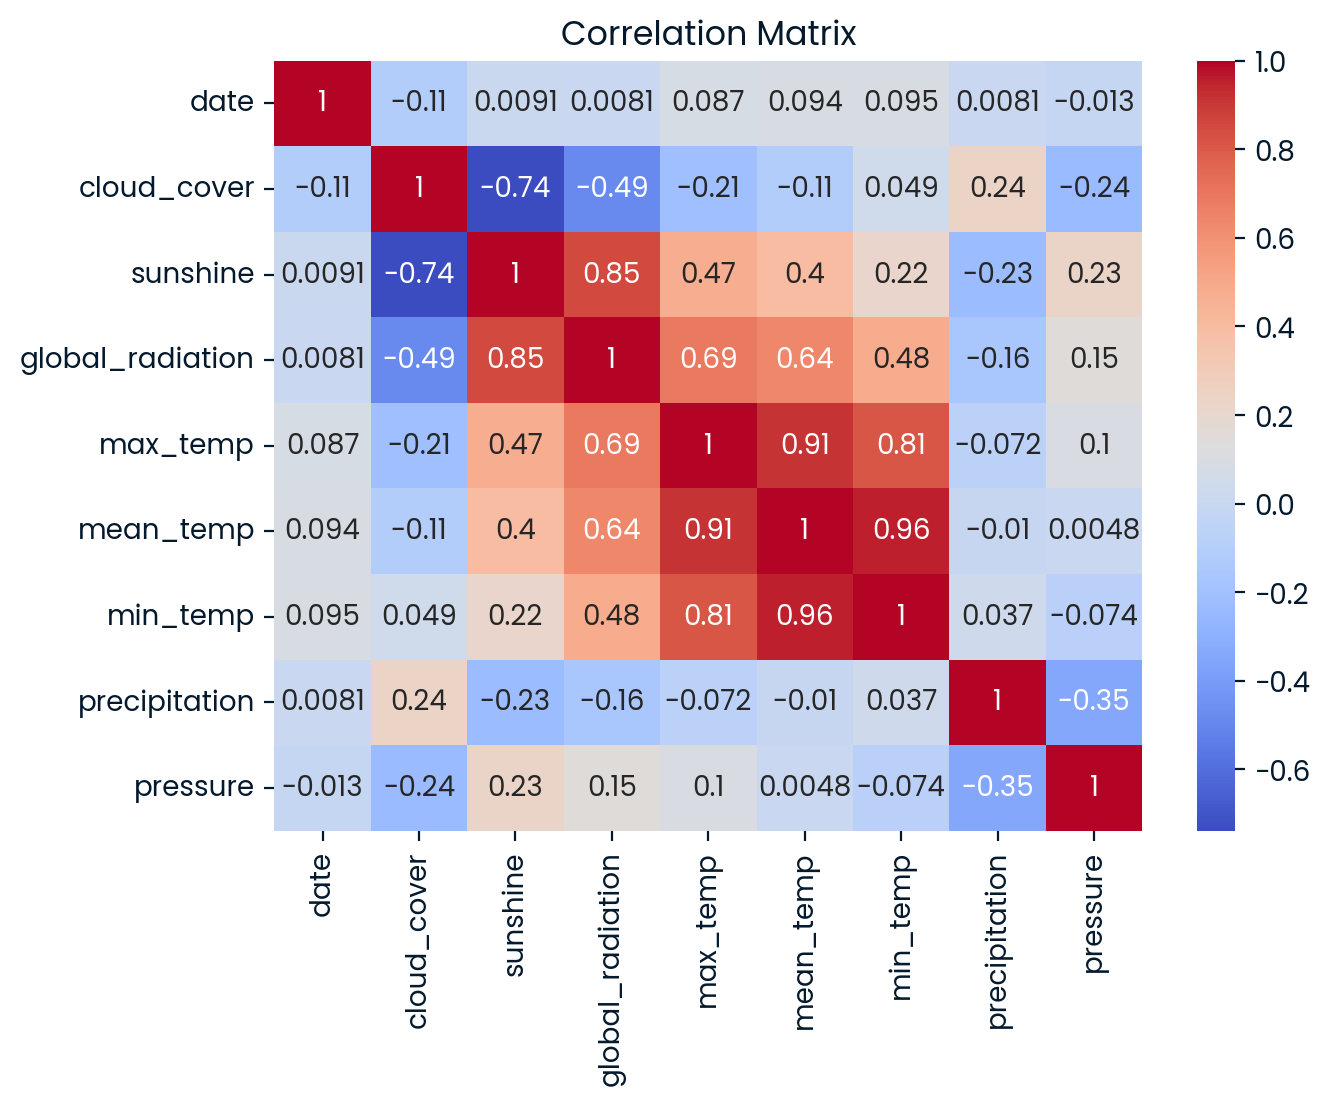

In [108]:
plt.figure(figsize=(7,5))
sns.heatmap(weather.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [109]:
weather = weather.drop('precipitation', axis=1) # negative value in percentage of relativiy to mean temp
weather = weather.drop('cloud_cover', axis=1) # negative value in percentage of relativiy to mean temp

In [110]:
imp_col = ['global_radiation', 'max_temp', 'min_temp', 'mean_temp', 'pressure']
imputer = SimpleImputer(strategy='mean')
weather[imp_col]= imputer.fit_transform(weather[imp_col])

In [111]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              15341 non-null  int64  
 1   sunshine          15341 non-null  float64
 2   global_radiation  15341 non-null  float64
 3   max_temp          15341 non-null  float64
 4   mean_temp         15341 non-null  float64
 5   min_temp          15341 non-null  float64
 6   pressure          15341 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 839.1 KB


In [112]:
X = weather.drop('mean_temp', axis=1)
y = weather['mean_temp']

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [113]:
mlflow.set_experiment('London experiment')

<Experiment: artifact_location='file:///work/files/workspace/mlruns/510030708741393472', creation_time=1760559615886, experiment_id='510030708741393472', last_update_time=1760559615886, lifecycle_stage='active', name='London experiment', tags={}>

In [114]:
with mlflow.start_run(run_name='LinearRegression'): #to avoid the need to close it explicitly
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred_lr = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred_lr, squared=False)
    
    mlflow.log_param('model_type', 'LinearRegression')
    mlflow.log_metric('rmse', rmse)
    mlflow.sklearn.log_model(model, 'model')

mlflow.end_run()

In [115]:
for depth in [3, 5, 10, 20]:
    with mlflow.start_run(run_name= f'DecisionTree max_depth= {depth}'):
        model = DecisionTreeRegressor(max_depth=depth, random_state=42)
        model.fit(X_train, y_train)
        y_pred_lr = model.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred_lr, squared=False)
        
        mlflow.log_param('model_type', 'DecisionTreeRegressor')
        mlflow.log_param('max_depth', depth)
        mlflow.log_metric('rmse', rmse)
        mlflow.sklearn.log_model(model, 'model')

mlflow.end_run()

In [116]:
for estm in [50, 100, 200, 300, 500]:
    with mlflow.start_run(run_name= f'RandomForest n_estimators= {estm}'):
        model = RandomForestRegressor(n_estimators=estm, random_state=42)
        model.fit(X_train, y_train)
        y_pred_rf = model.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred_rf, squared=False)
        
        mlflow.log_param('model_type', 'RandomForestRegressor')
        mlflow.log_param('n_estimators', estm)
        mlflow.log_metric('rmse', rmse)
        mlflow.sklearn.log_model(model, 'model')

mlflow.end_run()

In [117]:
experiment_results = mlflow.search_runs() 

In [118]:
best_run = experiment_results.sort_values("metrics.rmse").iloc[0]

if best_run["metrics.rmse"] <= 3:
    print("Goal achieved!")
    print(best_run['params.model_type'])
else:
    print("RMSE too high. Try tuning further.")

Goal achieved!
LinearRegression
